In [ ]:
# Name: Sitong Mu; Github username: edsml-sm1122

This code to explore generalization of MLP

As the data has a shape of (track, time, space, parameters). The first part use unseen track data to test the model (track 45, 83, 77).

In [ ]:
!pip install pycm livelossplot
%pylab inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.4/599.4 kB 18.8 MB/s eta 0:00:00
Populating the interactive namespace from numpy and matplotlib


In [ ]:
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
import datetime, time
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
from tqdm import tqdm
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from livelossplot import PlotLosses
from pycm import *
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from torchsummary import summary

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# to import utilitis
import sys
sys.path.insert(0,'/content/drive/MyDrive/IRP/codefinal')
from utilities import *

In [ ]:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


In [ ]:
#split the data into 5 chunks

#track, time(1800s), space(0.01degree,~1km), ['MWD','PWP','SWH','TWD','WiD','WiS']
m25 = np.load('/content/drive/MyDrive/IRP/data/structured/DepthContour25m.npy')
# m25del = m25[[45,83,77],...]
m25 = np.delete(m25, (45,83,77),axis=0)
print(f"Before reshaping: {np.shape(m25)}")

m0 = np.load('/content/drive/MyDrive/IRP/data/structured/Coastline0p01.npy')
# m0del = m0[[45,83,77],...]
m0 = np.delete(m0, (45,83,77),axis=0)
print(f"Before reshaping: {np.shape(m0)}")


m25 = m25[:,1:,:,:]
m0 = m0[:,1:,:,:]

#  chucnk the tar
tar = m0[:,:,:,2]
print(tar.shape)
tar = np.reshape(tar,(np.shape(tar)[0],np.shape(tar)[1],int(np.shape(tar)[2]/5), 5))

tar_rs = np.reshape(tar, (np.shape(tar)[0]*np.shape(tar)[1],np.shape(tar)[2],np.shape(tar)[3]))
print(f"After reshaping: {tar_rs.shape}")

feature25m = np.reshape(m25, (np.shape(m25)[0]*np.shape(m25)[1],np.shape(m25)[2],np.shape(m25)[3]))
print(f"After reshaping: {feature25m.shape}")

# convert 2 degree dimentions to sin and cos, now the third dimention is ['sin(MWD)',cos(MWD),'PWP','SWH','TWD',sin('WiD'),cos(WiD),'WiS']
print('after FE')
feature25m = convert_deg_to_sin_cos(feature25m)

# chunk the features
feature25m = np.reshape(feature25m,(np.shape(feature25m)[0],int(np.shape(feature25m)[1]/5),5, np.shape(feature25m)[-1]))
feature25m = np.transpose(feature25m, (0, 1, 3, 2))
print(feature25m.shape)

#further reshape
print('Final reshaping')
feature25m = feature25m.reshape(feature25m.shape[0],feature25m.shape[1]*feature25m.shape[2],feature25m.shape[-1])
print(feature25m.shape)

tar_rs[np.isnan(tar_rs)] = 0
tar_rs = np.flip(tar_rs,axis=2)# as the index order of points is opposite for coastline and offshore, flip the offshore points by space index

Before reshaping: (185, 98, 155, 6)
Before reshaping: (185, 98, 145, 6)
(185, 97, 145)
After reshaping: (17945, 29, 5)
After reshaping: (17945, 155, 6)
after FE
(17945, 31, 8, 5)
Final reshaping
(17945, 248, 5)


In [ ]:
n_hidden = 64
n_layers = 2
# embedding_dim = input_size
# n_unique_words = len(words_dataset.unique_words)
batch_size = 256
sequence_length = 9

lr = 1e-3

n_epochs = 80

In [ ]:
def trainwithout(feature,target):
  """
  Generate predictions for different spatial regions using a pre-trained model and
  evaluates these predictions against actual target values. Optionally plots the results.

  Parameters:
  - mean (numpy.ndarray): Mean values for feature normalization, calculated during training.
  - std (numpy.ndarray): Standard deviation values for feature normalization, calculated during training.
  - model (torch.nn.Module): Pre-trained PyTorch model.
  - mode (int): A flag to determine the mode of operation:
                0: Use new mean and std for feature normalization.
                1: Use the provided mean and std for feature normalization.

  Steps:
  1. Loops through each target dimension in `tar_rs`.
  2. Normalizes the features if mode is 0, or scales them using the provided mean and std if mode is 1.
  3. Makes predictions using the pre-trained model.
  4. Calculates the Root Mean Square Error (RMSE) between the predictions and actual targets.
  5. Optionally plots the results if mode is 0.

  Returns:
  - mselist (list): List of RMSE values for each spatial region.

  Note:
  - This function assumes the presence of global variables such as `feature25m` and `tar_rs`.
    It's advisable to pass these as parameters for a more robust implementation.
  - The function also assumes that PyTorch's device (CPU or GPU) is globally defined as `device`.
  """
  mean,std,feature = normalize(feature)
  input_size = feature.shape[-1]
  output_size= target.shape[-1]
  X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.2)
  # print(input_size)
  traindata = lstmDataset(X_train,y_train,sequence_length=sequence_length)
  # dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
  valdata = lstmDataset(X_test,y_test,sequence_length=sequence_length)

  lstm_gen = LSTM_GEN(input_size, output_size, n_hidden, n_layers,device=device).to(device)                                            # instantiate model and send it to the GPU
  train_loader = DataLoader(traindata, batch_size=batch_size, shuffle=False)
  validation_loader = DataLoader(valdata, batch_size=batch_size, shuffle=False)

  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(lstm_gen.parameters(), lr=lr)

  # Keep track of losses for plotting
  liveloss = PlotLosses()
  for epoch in tqdm(range(n_epochs)):
      logs = {}
      # print(criterion)
      train_loss = torch.sqrt(train_lstm_gen(lstm_gen, optimizer, criterion, train_loader,device=device))
      val_loss = torch.sqrt(val_lstm_gen(lstm_gen, criterion, validation_loader,device=device))
      print('1')
      # res = predict_lstm_gen(valdata, lstm_gen, next_words=len(valdata))
      # print(res.shape)
      # mserror = mse(res,valdata[sequence_length:])

      print(epoch,train_loss)

      logs['' + 'log loss'] = train_loss.item()
      logs['val_' + 'log loss'] = val_loss.item()
      liveloss.update(logs)
      liveloss.draw()

  return mean, std, lstm_gen


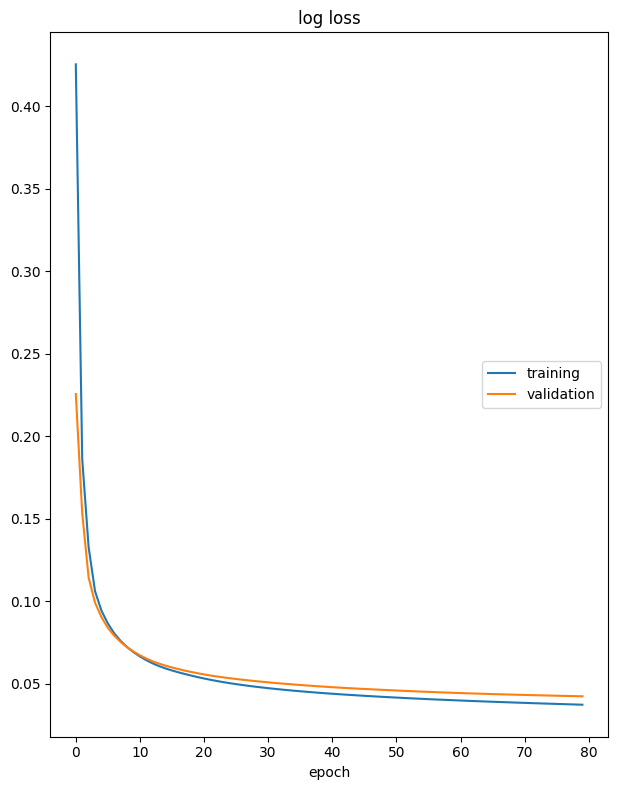

100%|██████████| 80/80 [01:53<00:00,  1.42s/it]

log loss
	training         	 (min:    0.037, max:    0.425, cur:    0.037)
	validation       	 (min:    0.042, max:    0.226, cur:    0.042)


In [ ]:
meanmid, stdmid, modelmid = trainwithout(feature25m[...,2],tar_rs[...,2])# use the 3rd chunk to train a model

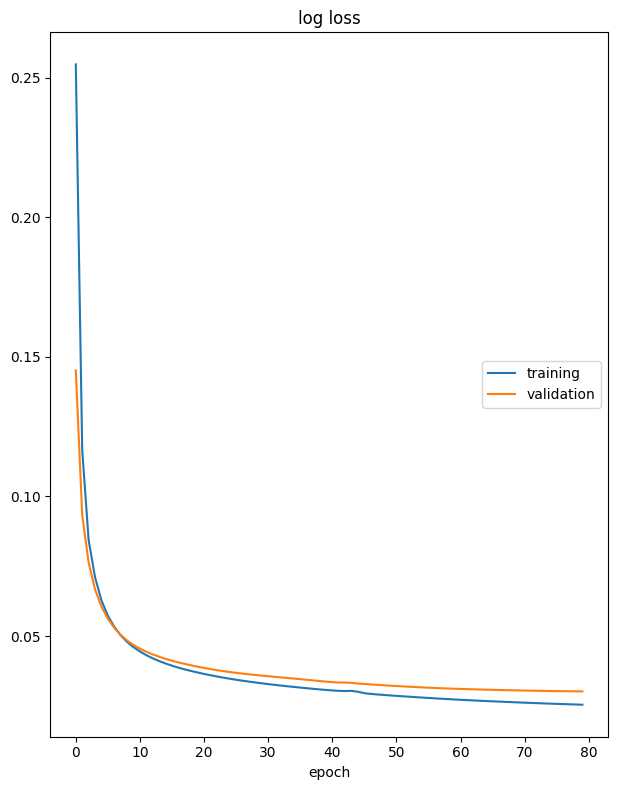

100%|██████████| 80/80 [01:57<00:00,  1.47s/it]

log loss
	training         	 (min:    0.025, max:    0.255, cur:    0.025)
	validation       	 (min:    0.030, max:    0.145, cur:    0.030)


In [ ]:
meanleft,stdleft,modelleft = trainwithout(feature25m[...,0],tar_rs[...,0])

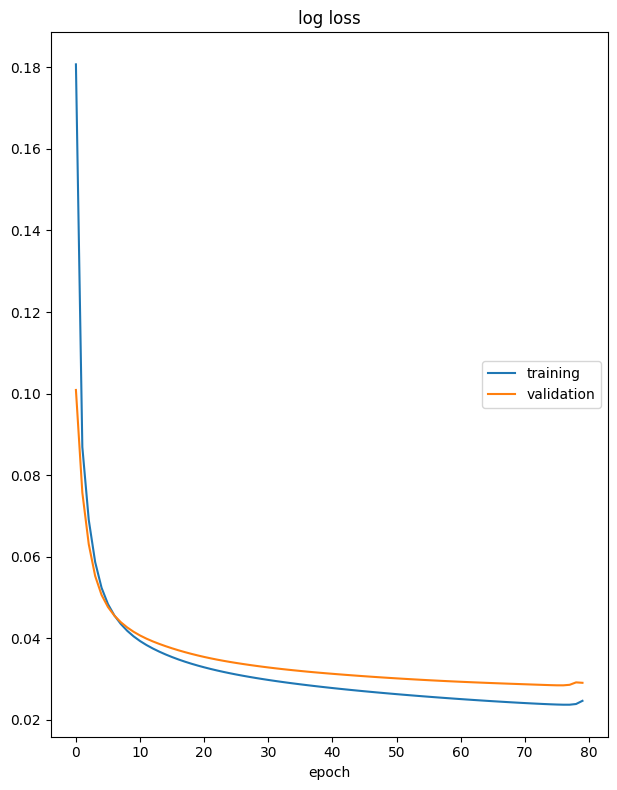

100%|██████████| 80/80 [01:56<00:00,  1.46s/it]

log loss
	training         	 (min:    0.024, max:    0.181, cur:    0.025)
	validation       	 (min:    0.028, max:    0.101, cur:    0.029)


In [ ]:
meanright, stdright, modelright = trainwithout(feature25m[...,-1],tar_rs[...,-1])

In [ ]:
from sklearn.metrics import mean_squared_error as mse

In [ ]:
#normalization
def normalize(arr):
    """
    Normalizes a NumPy array.

    Parameters:
    arr (np.array): Input array to be normalized.

    Returns:
    mean (float): Mean of the input array along axis 0.
    std (float): Standard deviation of the input array along axis 0.
    arr_normalized (np.array): Normalized array.

    Note:
    - This function is different from the one in utilities.py
    """

    # Compute mean and std dev
    mean = np.mean(arr, axis=0)
    std = np.std(arr, axis=0)

    # Subtract mean and divide by std dev
    arr_normalized = (arr - mean) / std

    return mean, std, arr_normalized

def spacegener(mean,std,model,mode):

  """
  Generate predictions for different spatial regions using a pre-trained model and
  evaluates these predictions against actual target values. Optionally plots the results.

  Parameters:
  - mean (numpy.ndarray): Mean values for feature normalization, calculated during training.
  - std (numpy.ndarray): Standard deviation values for feature normalization, calculated during training.
  - model (torch.nn.Module): Pre-trained PyTorch model.
  - mode (int): A flag to determine the mode of operation:
                0: Use new mean and std for feature normalization.
                1: Use the provided mean and std for feature normalization.

  Steps:
  1. Loops through each target dimension in `tar_rs`.
  2. Normalizes the features if mode is 0, or scales them using the provided mean and std if mode is 1.
  3. Makes predictions using the pre-trained model.
  4. Calculates the Root Mean Square Error (RMSE) between the predictions and actual targets.
  5. Optionally plots the results if mode is 0.

  Returns:
  - mselist (list): List of RMSE values for each spatial region.

  Note:
  - This function assumes the presence of global variables such as `feature25m` and `tar_rs`.
    It's advisable to pass these as parameters for a more robust implementation.
  - The function also assumes that PyTorch's device (CPU or GPU) is globally defined as `device`.
  """
  mselist =[]

  for i in range(tar_rs.shape[-1]):
    if mode == 0:
      #use the mean and std of the feature, but not the chunk model trained on, see if better
      feature = feature25m[...,i]
      mean,std,feature = normalize(feature)

    if mode == 1:
      feature =(feature25m[...,i]-mean)/std

    tar = tar_rs[...,i]
    data = MyDataset(feature,tar,sequence_length=9)
    dataloader = DataLoader(data, batch_size=len(data), shuffle=False)
    feature_, tar_ = next(iter(dataloader))
    pre = model(feature_.to(device))
    err = torch.sqrt(nn.MSELoss()(pre.to(device),tar_.to(device)))
    mselist.append(err.cpu().detach().numpy())#rmse

    if mode == 0:
      fig = plt.figure(figsize=(12, 12))
      fignum = 9
      for ind,num in enumerate(generate_random_numbers(fignum, 0, 147)):
          plt.subplot(3, 3, ind+1)
          plt.plot(pre[num,-1,:].cpu().detach().numpy(), label=f'model res') # -1 here, use the last of the sequence as output
          plt.plot(tar[num], label=f'tar')

          plt.xlabel('nearshore point ind')
          plt.ylabel('SWH m')
          plt.title(f'inbatch_ind{i}')
          plt.legend()

    plt.suptitle(f'Test on space excluded_chunk{i+1}')
    plt.tight_layout()
    plt.show()

  return mselist

In [ ]:
print('mean value of target',tar_rs.mean(),'m')

mean value of target 0.15765817591440692 m


code below test the 3 models and plot the result predcting the 5 chunks

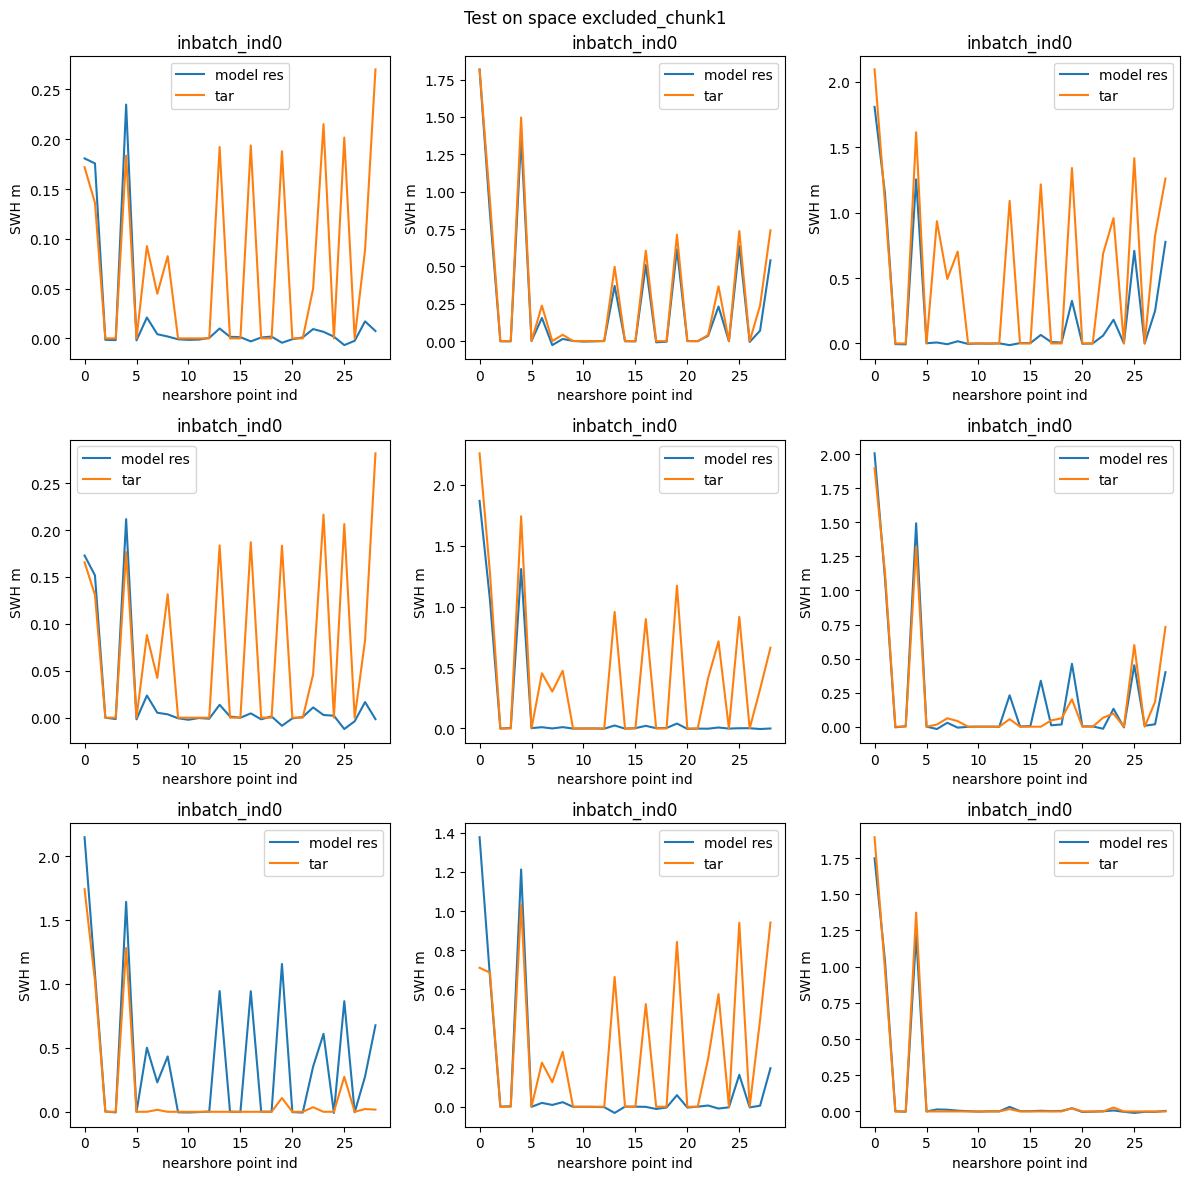

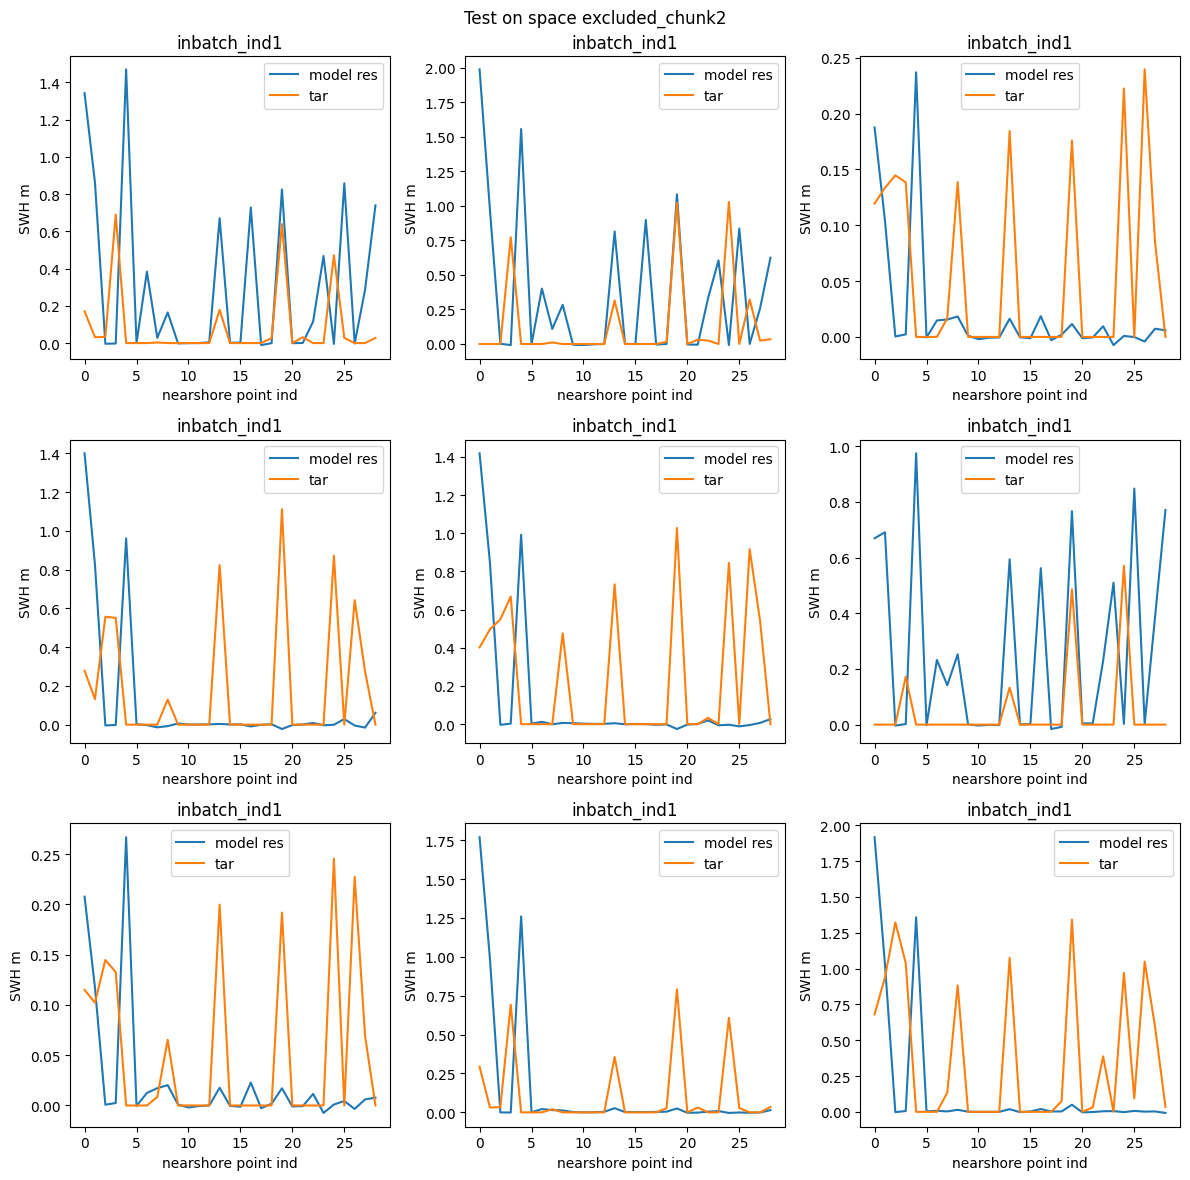

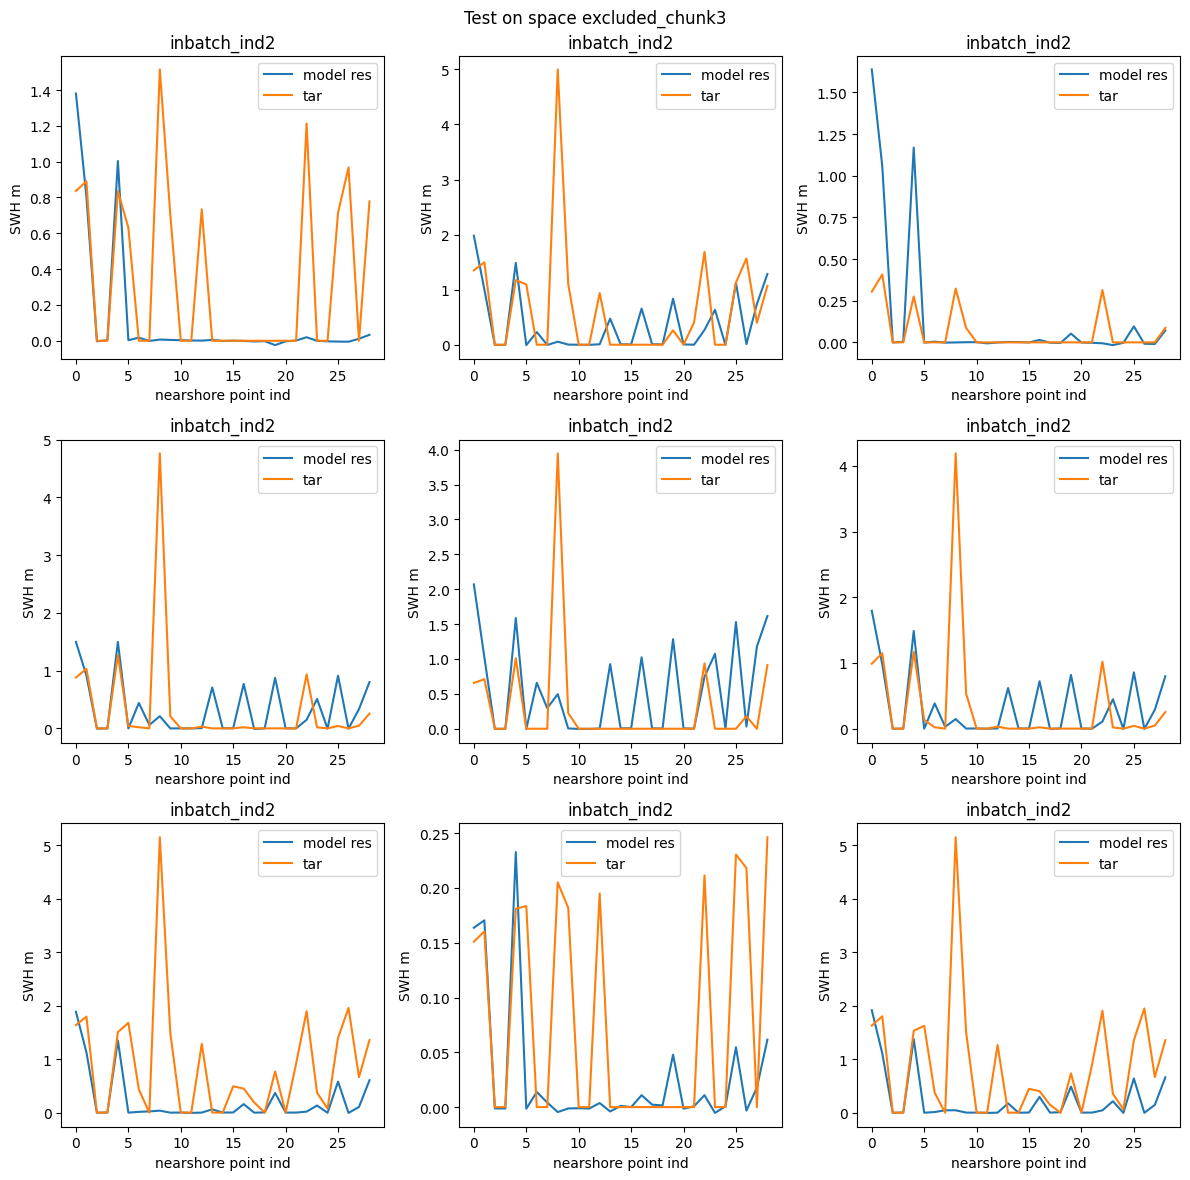

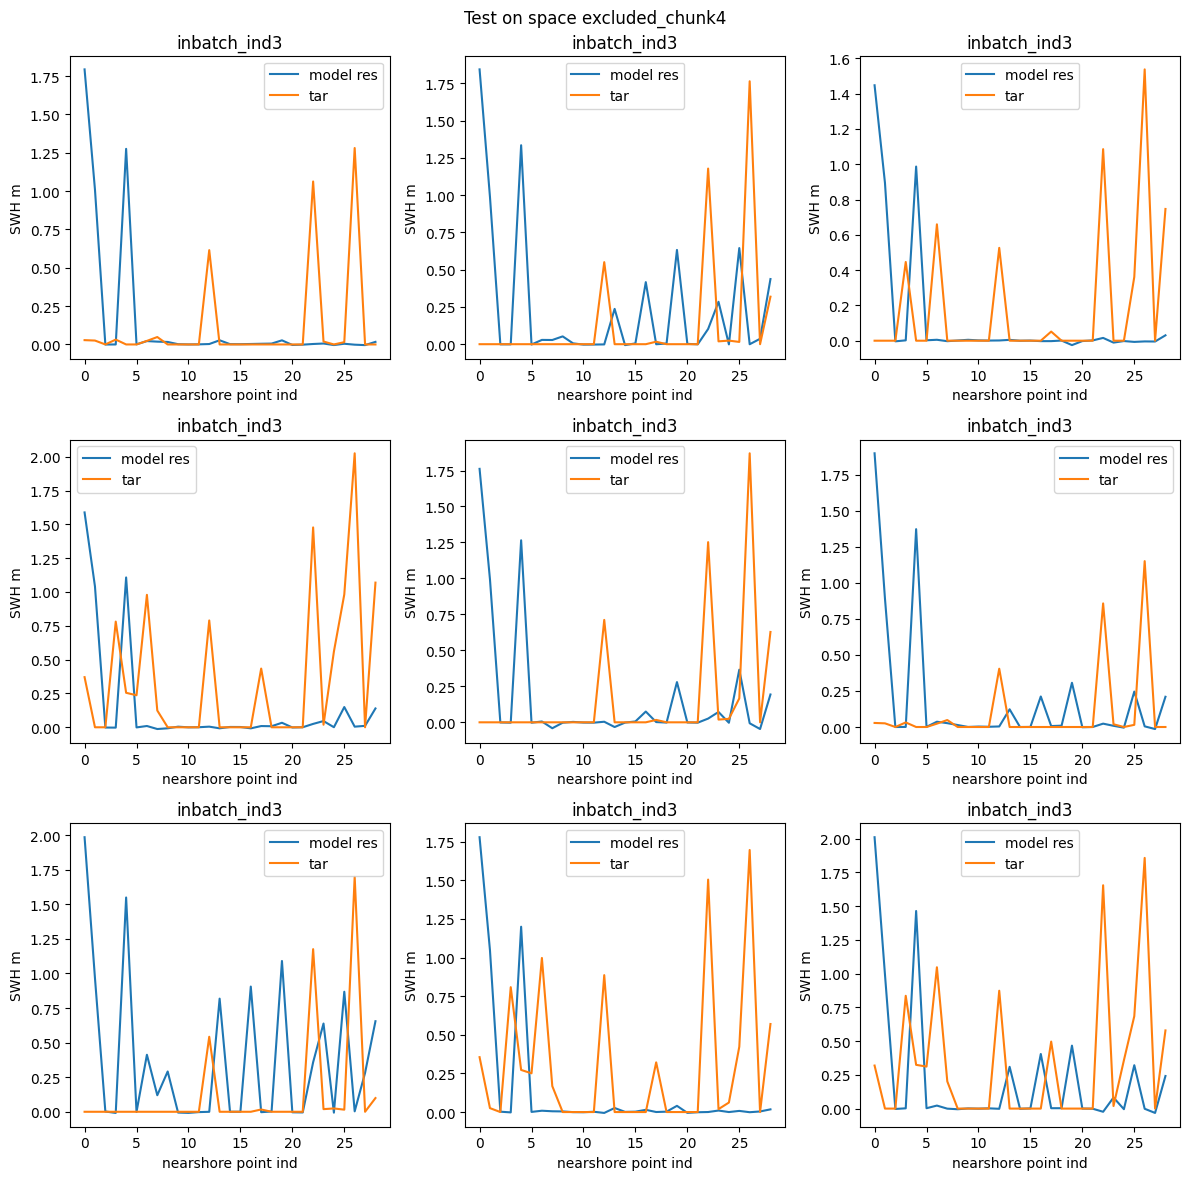

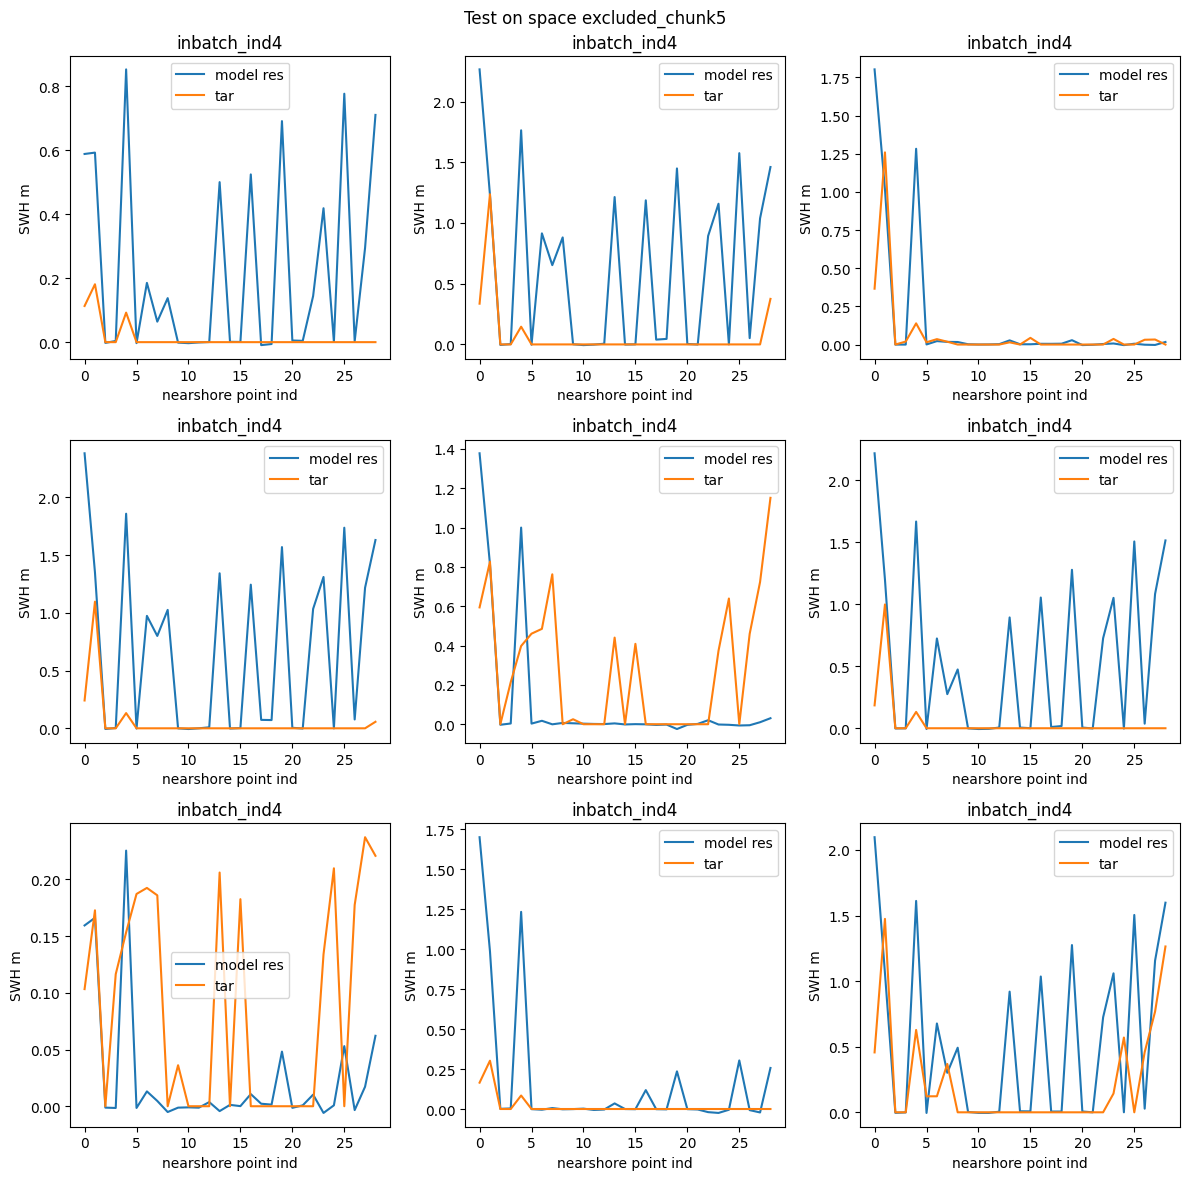

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

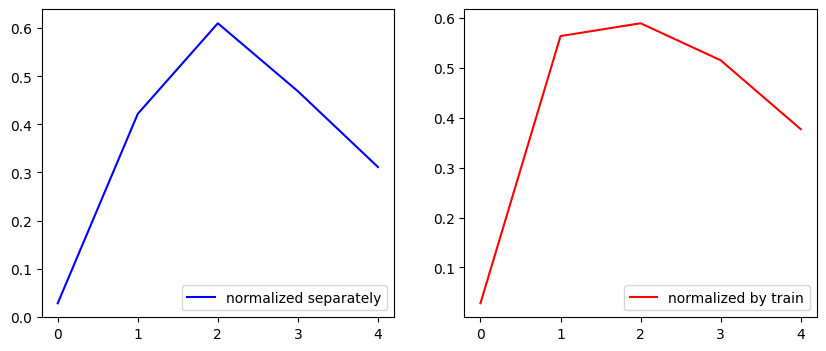

In [ ]:
leftlist0 = spacegener(meanleft,stdleft,modelleft,0)
leftlist1 = spacegener(meanleft,stdleft,modelleft,1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].plot(leftlist0,label='normalized separately',color='blue')
axes[0].legend()

axes[1].plot(leftlist1,label='normalized by train',color='red')
axes[1].legend()

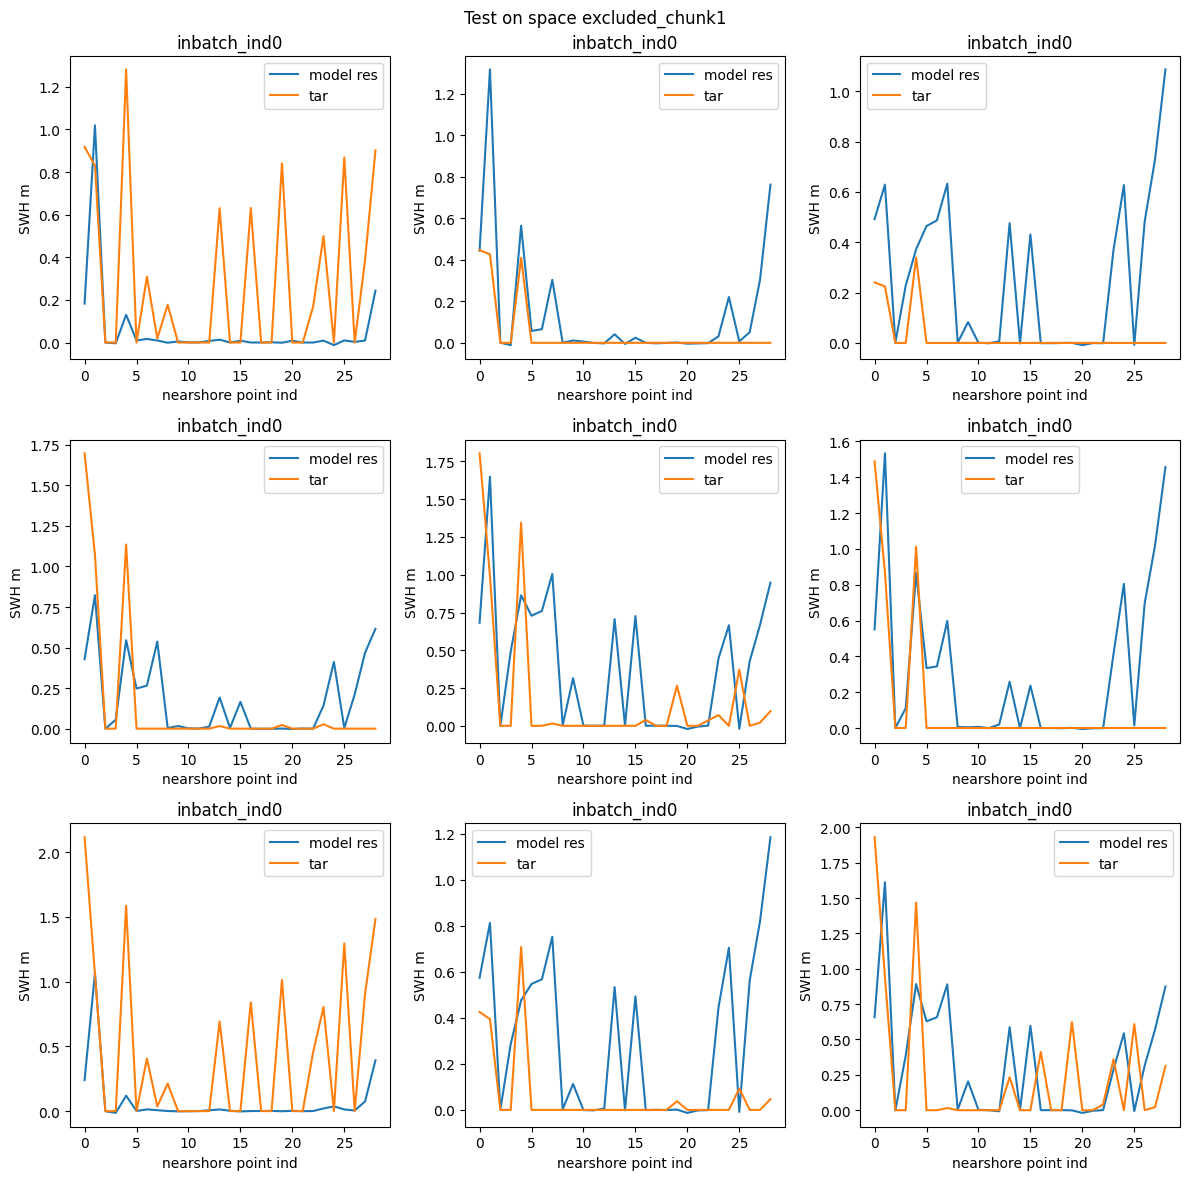

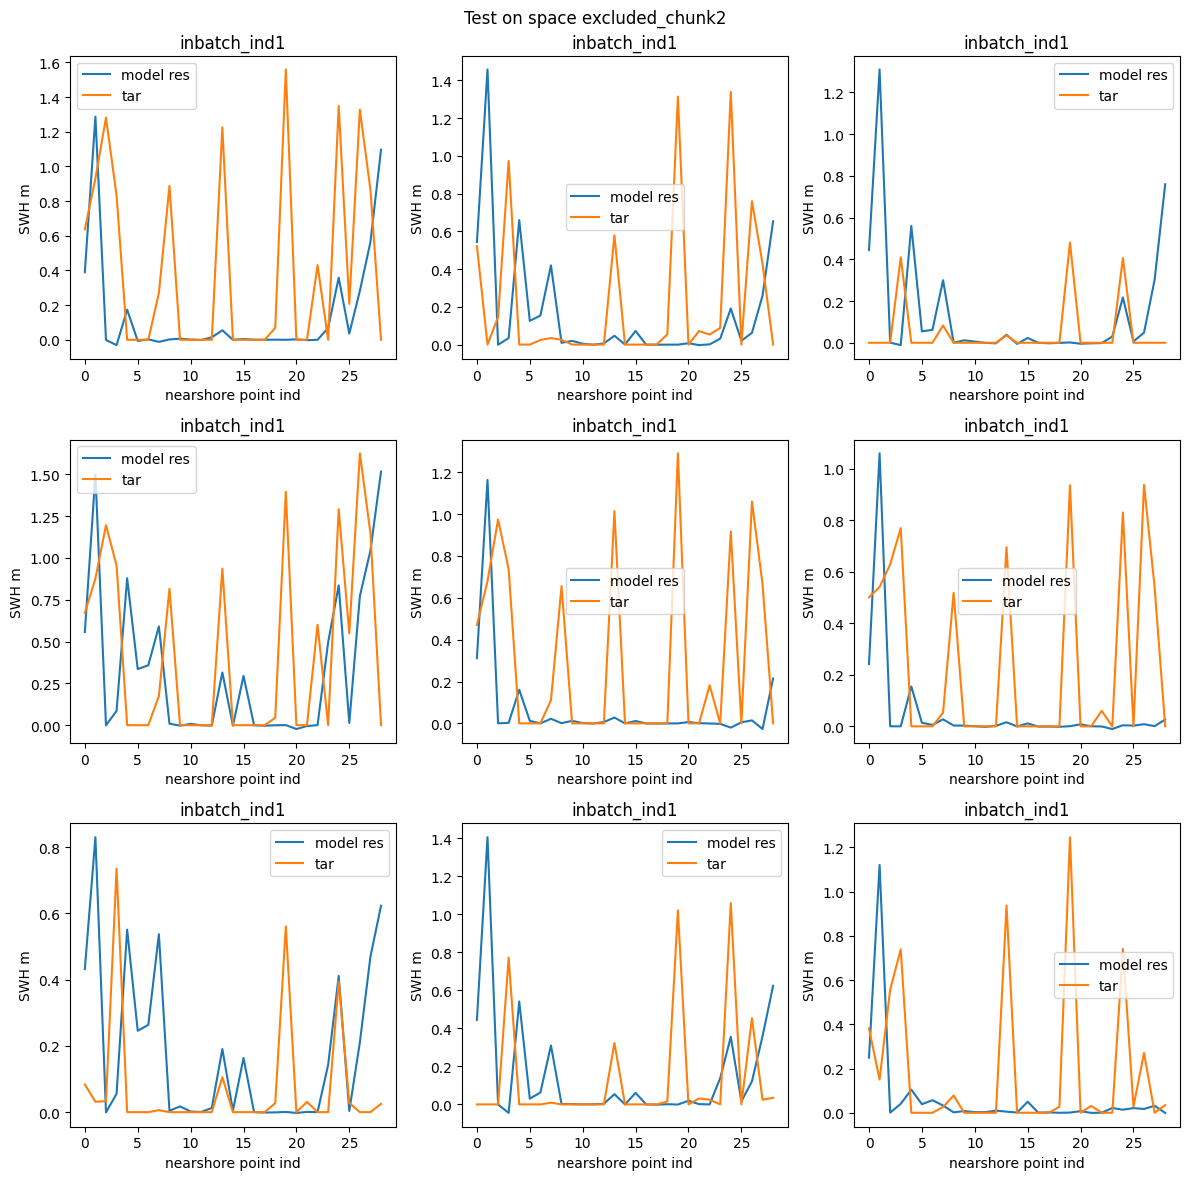

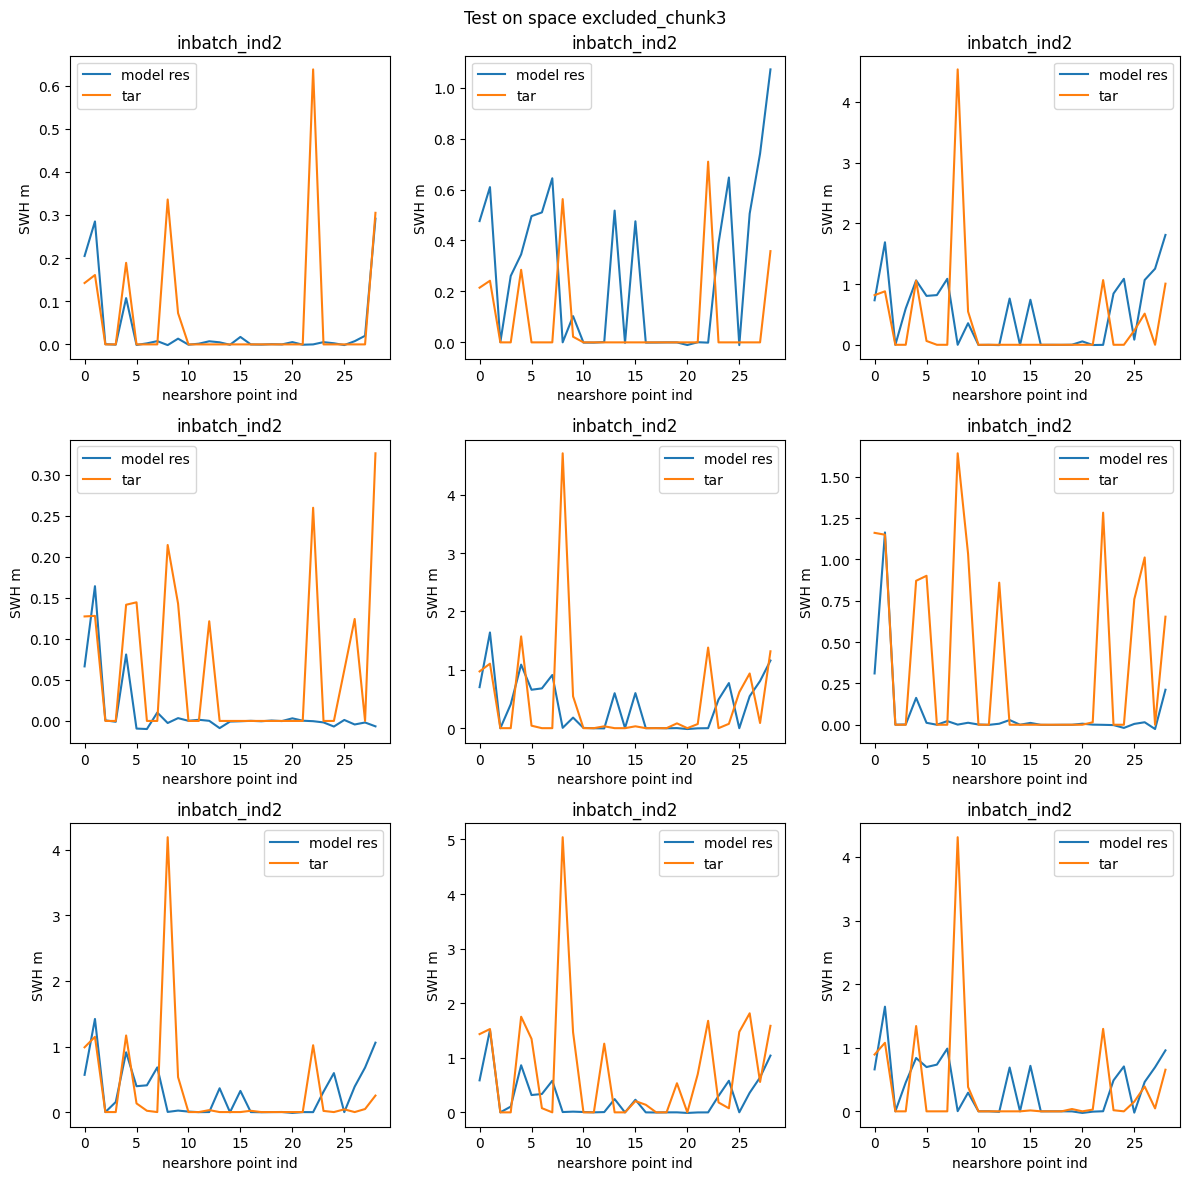

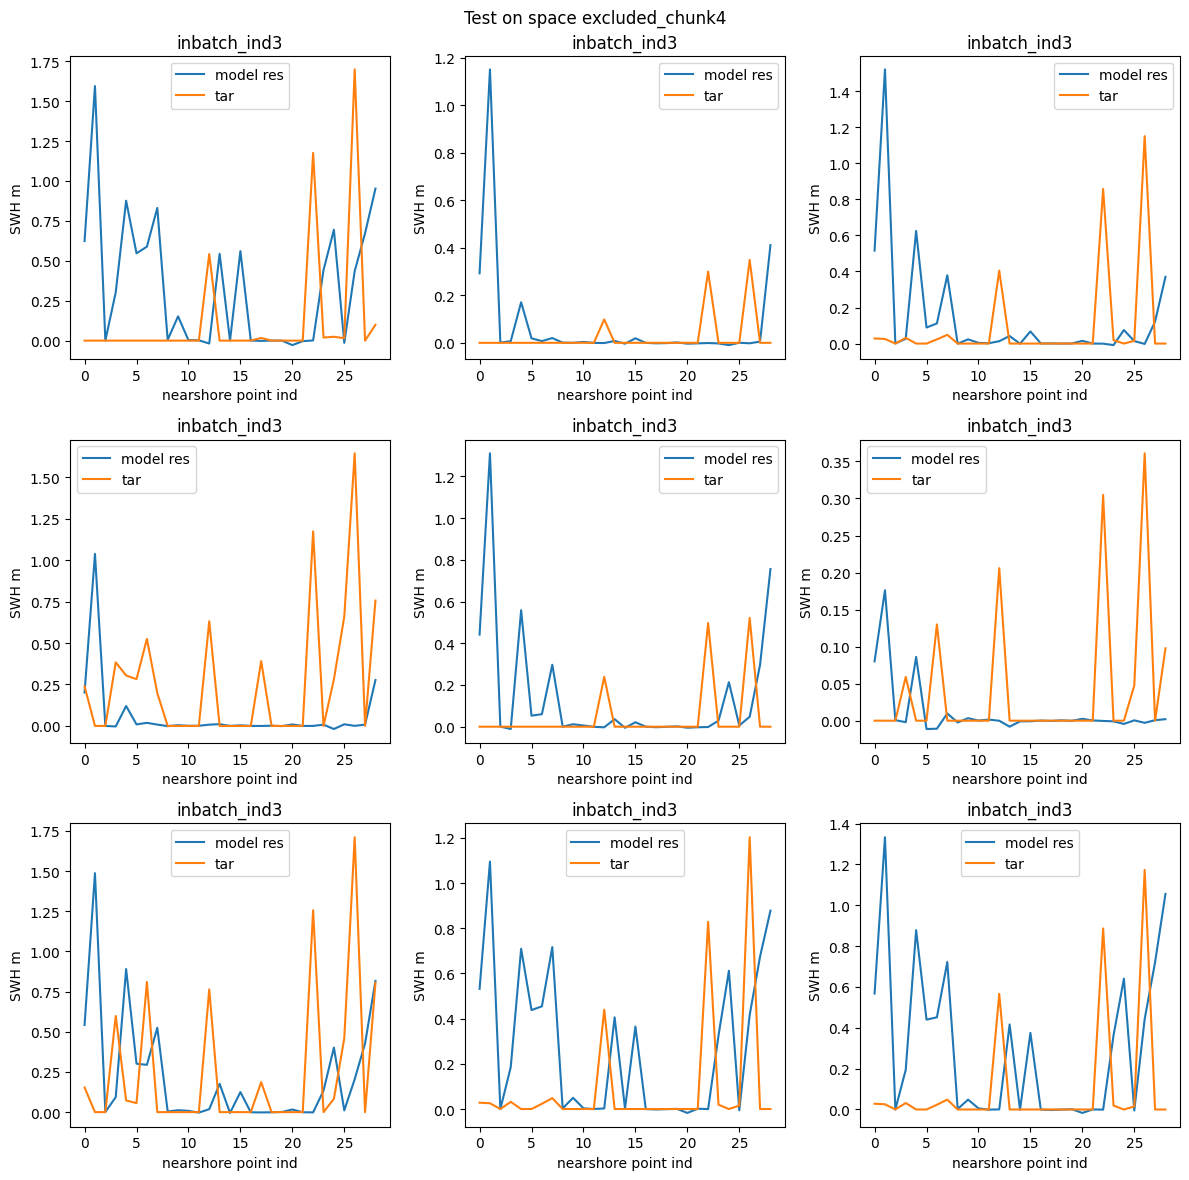

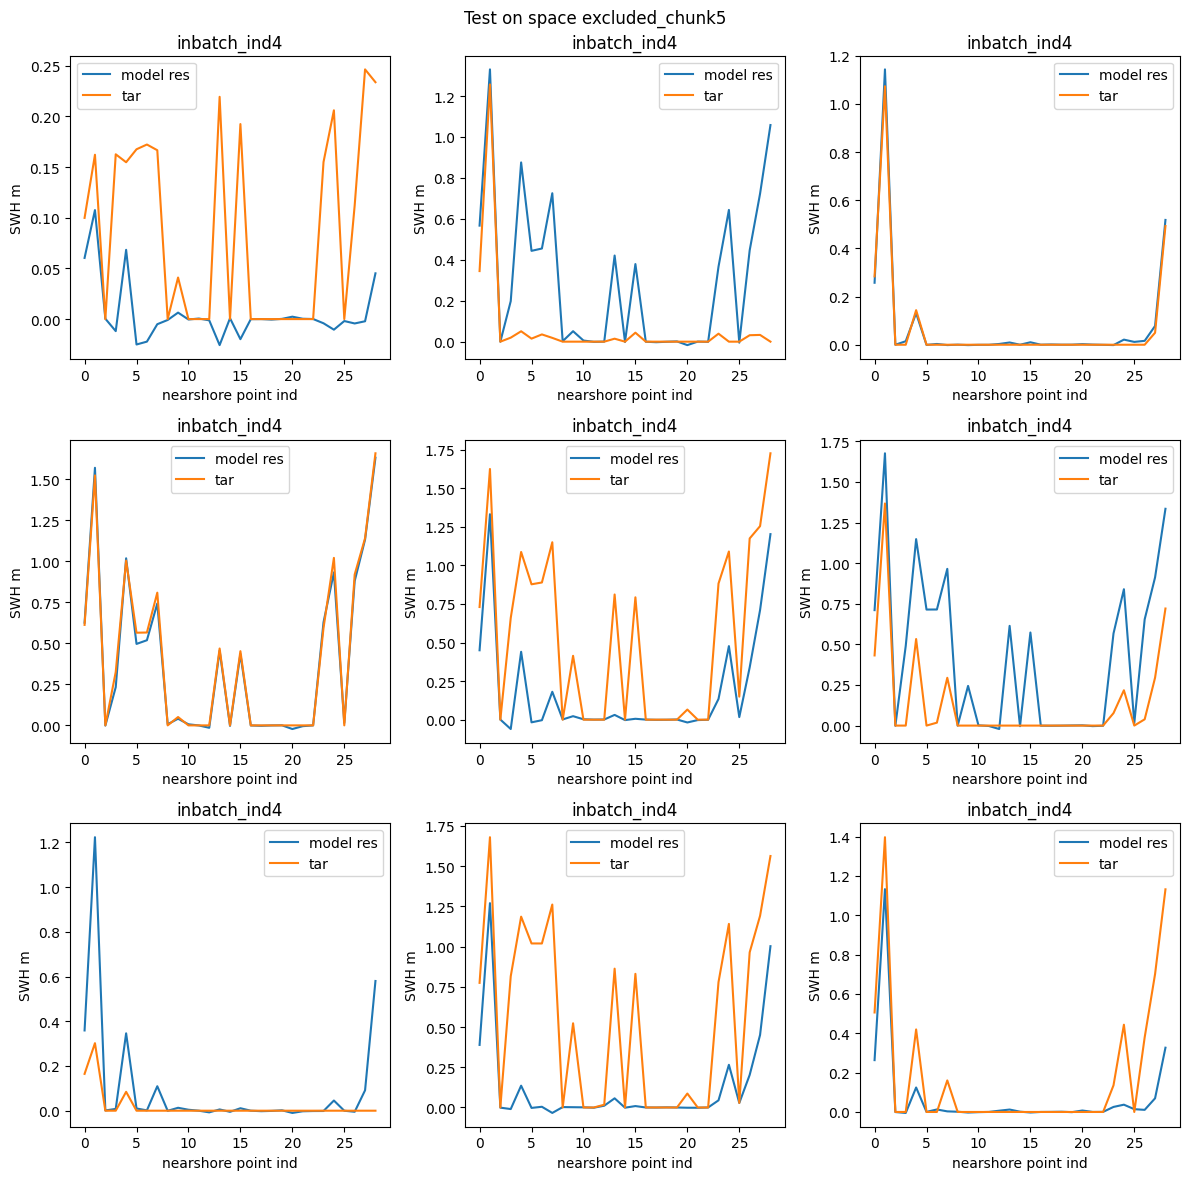

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

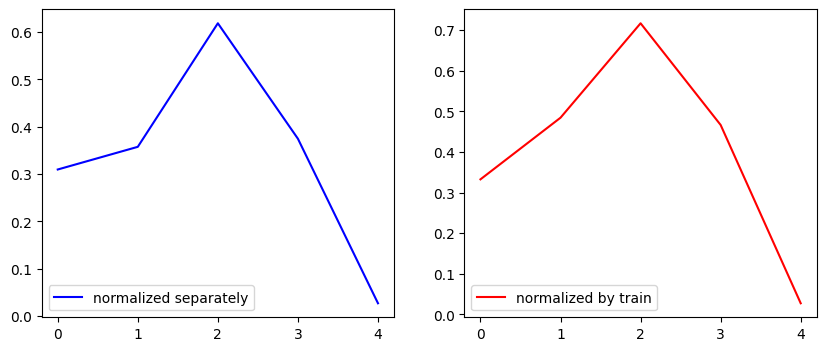

In [ ]:
rightlist0 = spacegener(meanright,stdright,modelright,0)
rightlist1 = spacegener(meanright,stdright,modelright,1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].plot(rightlist0,label='normalized separately',color='blue')
axes[0].legend()

axes[1].plot(rightlist1,label='normalized by train',color='red')
axes[1].legend()

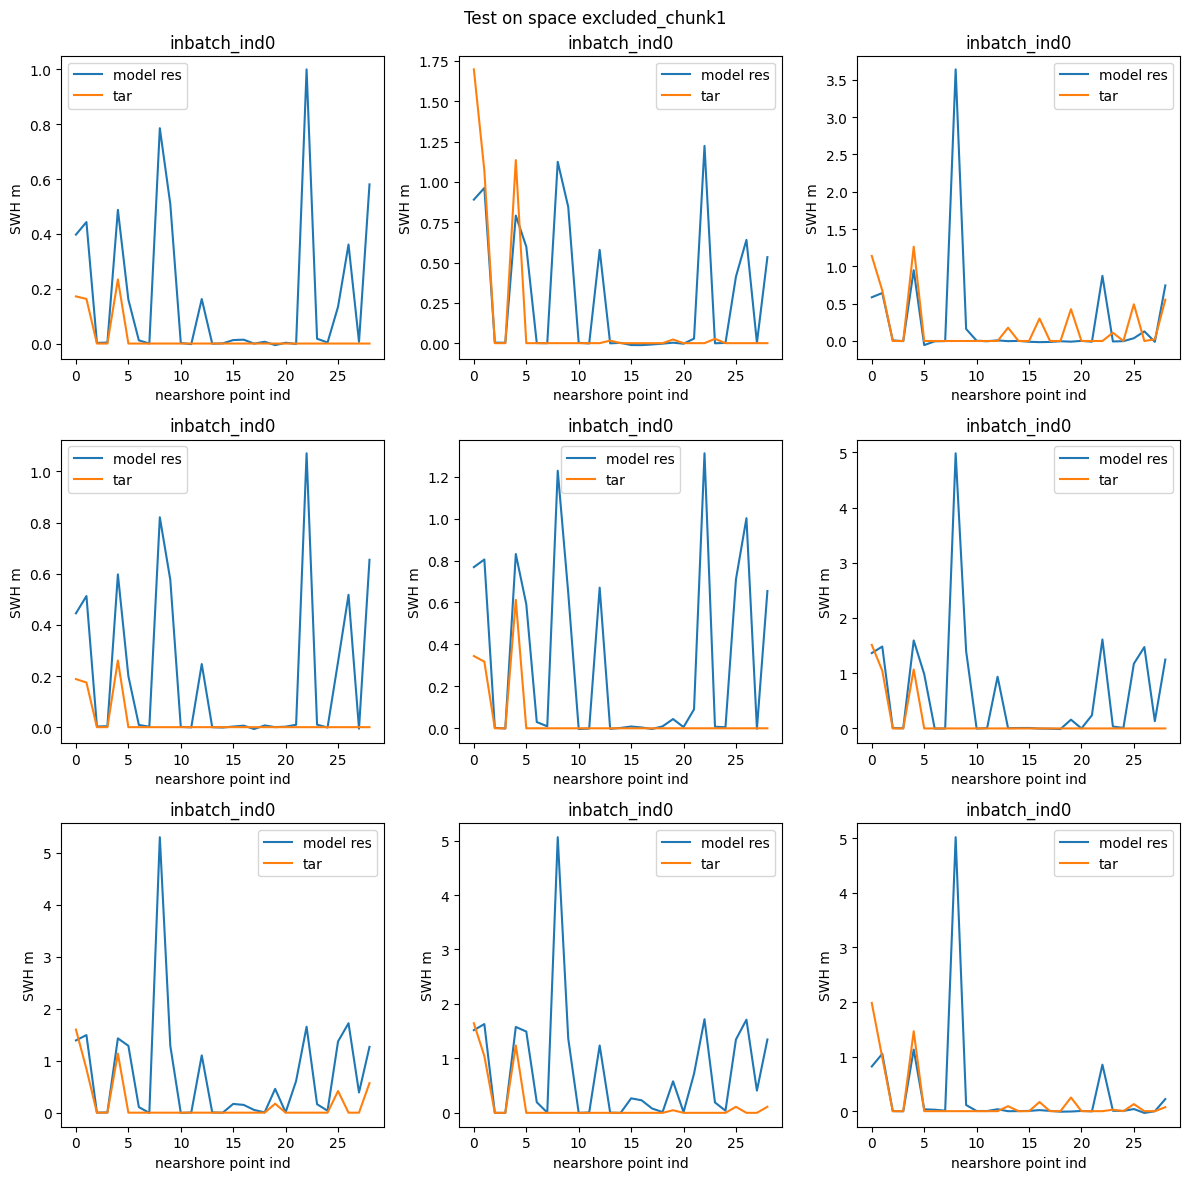

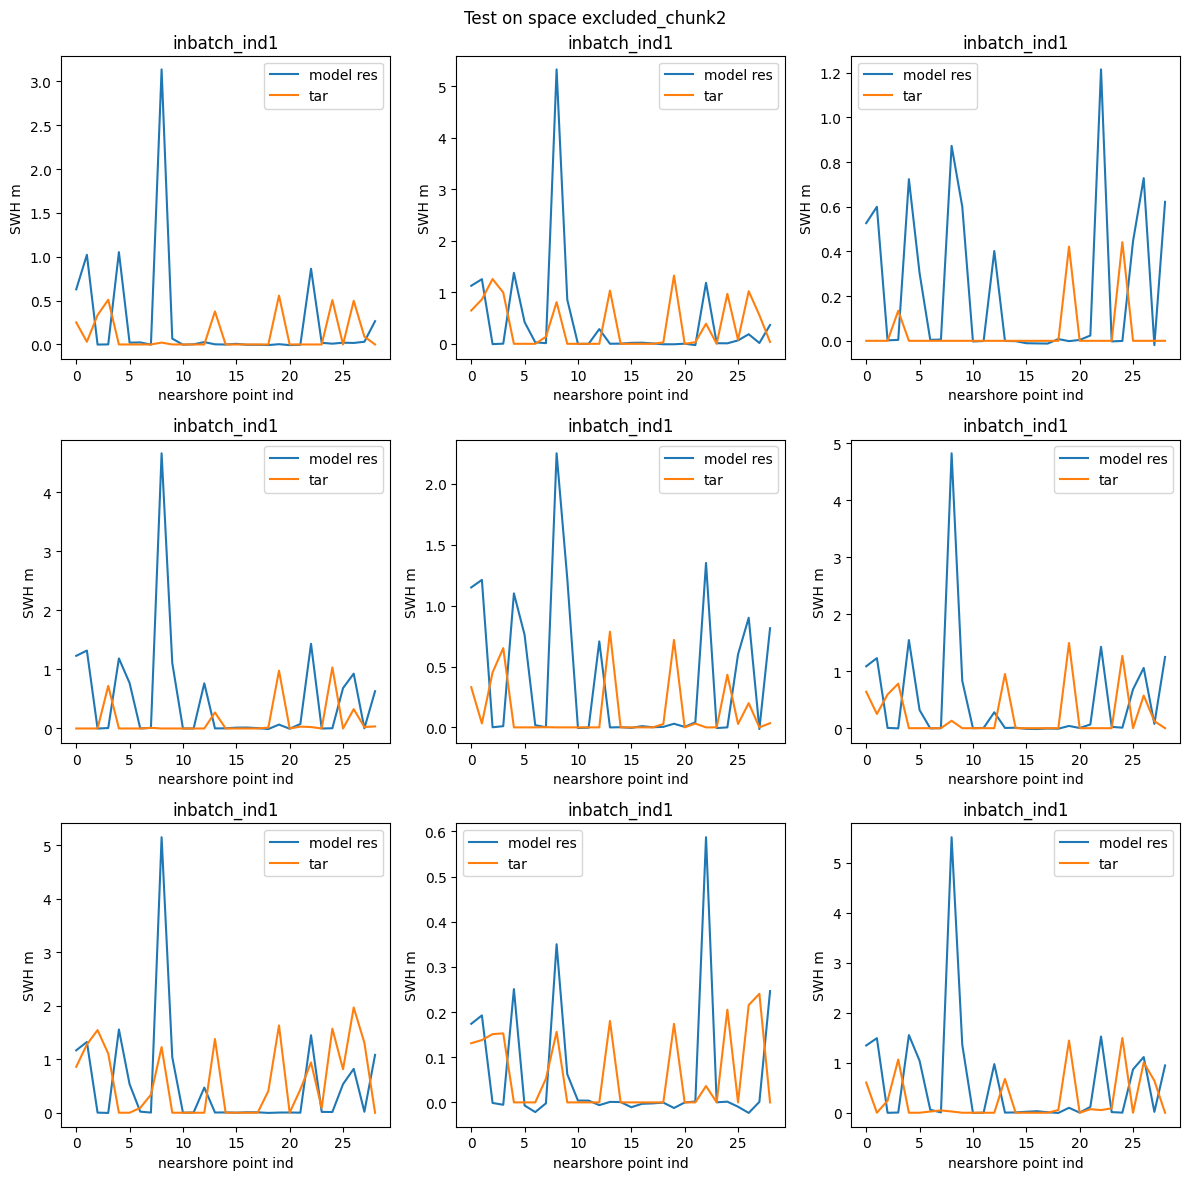

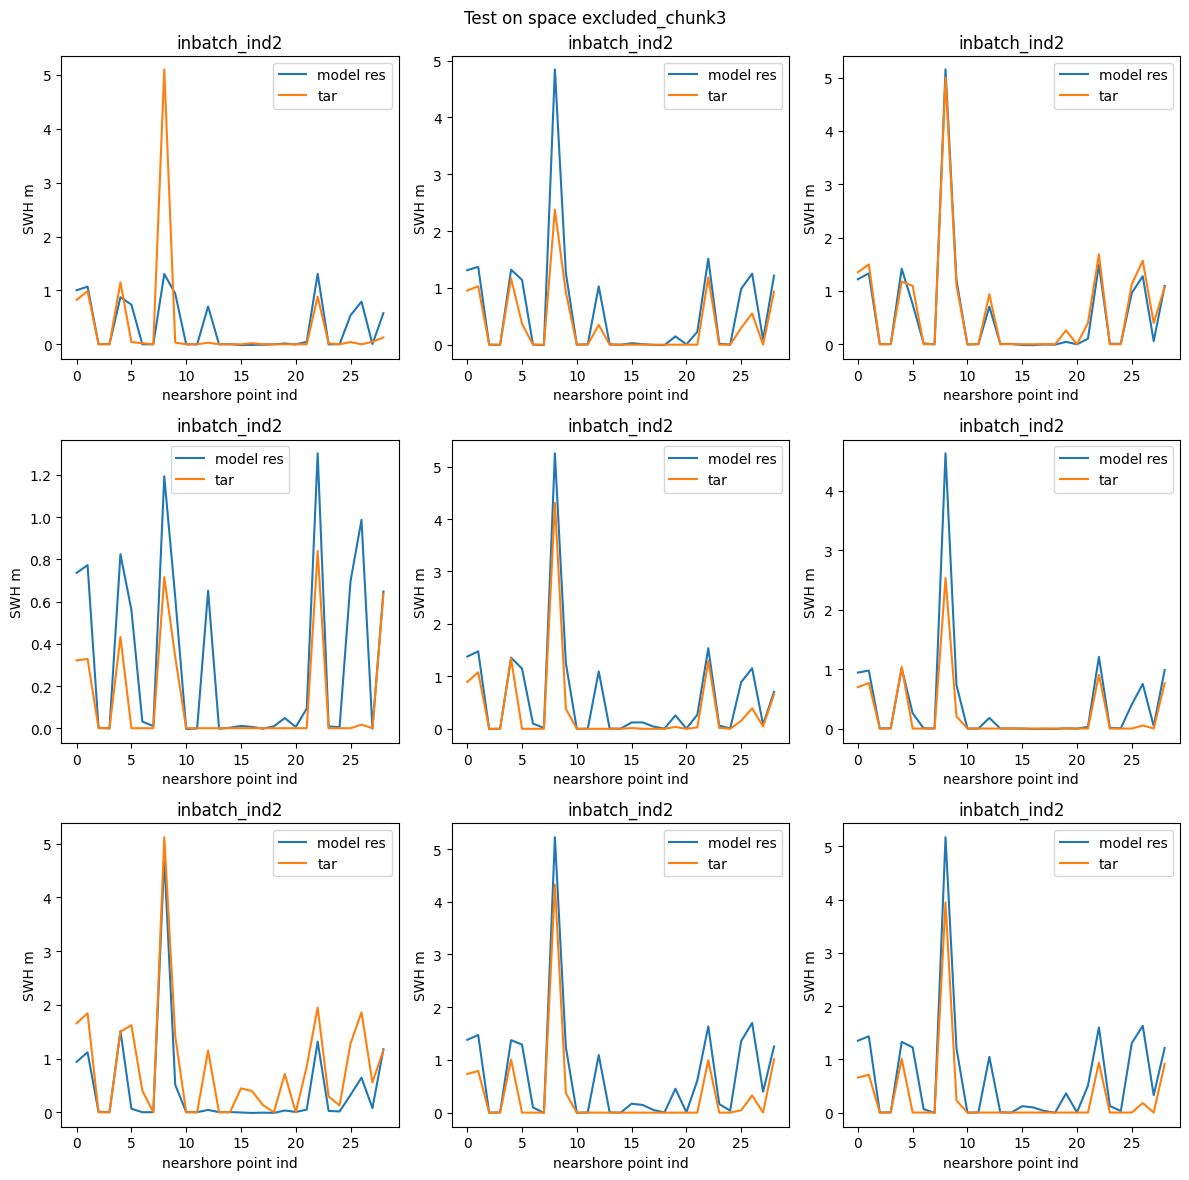

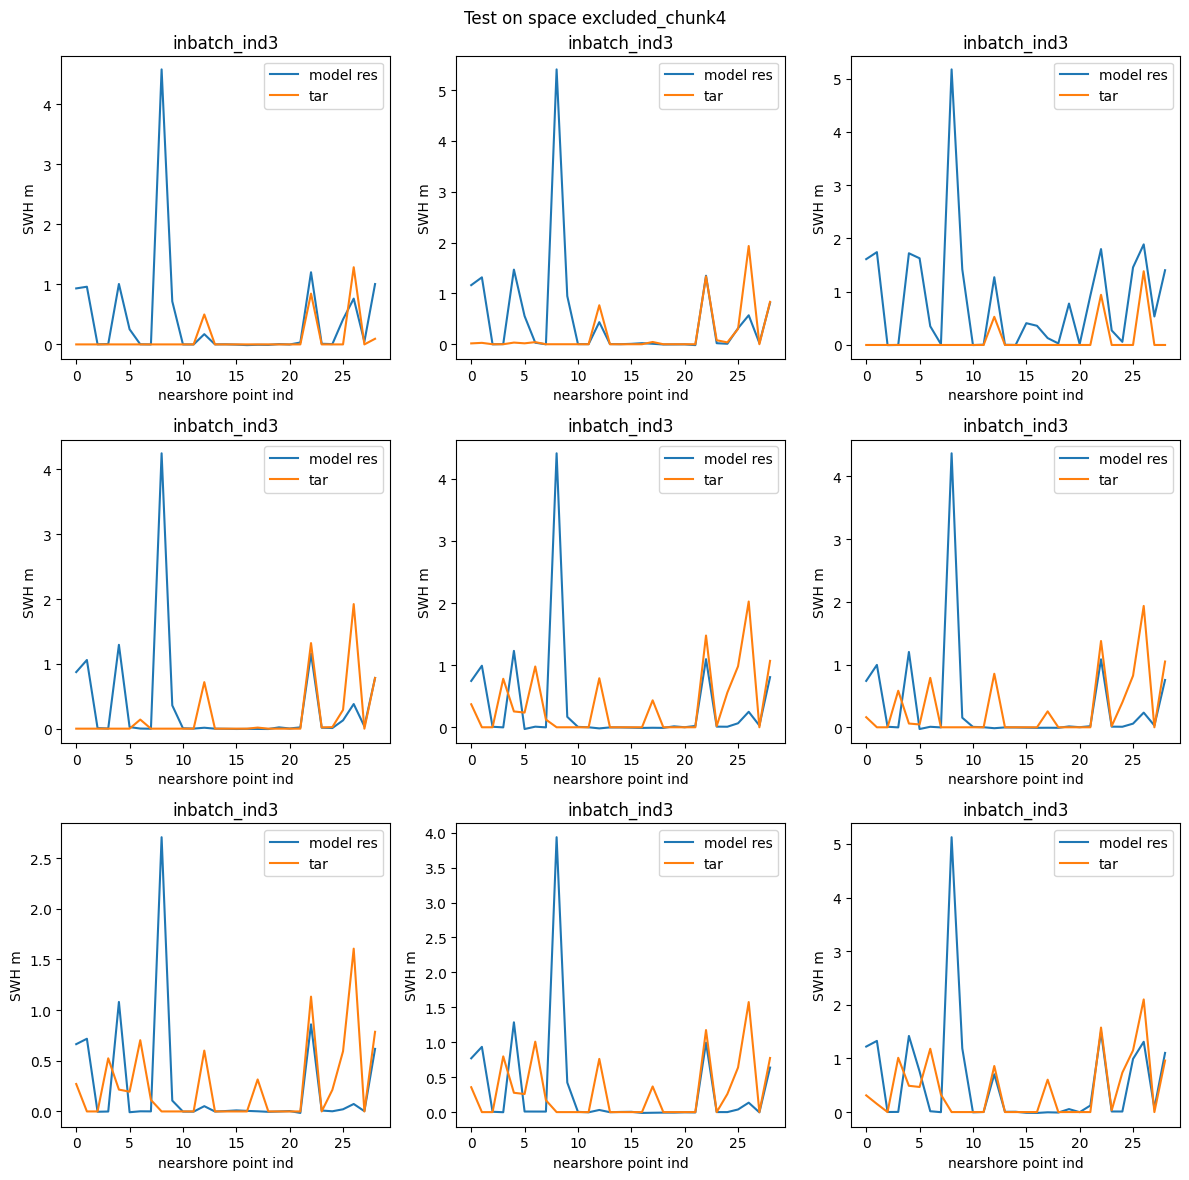

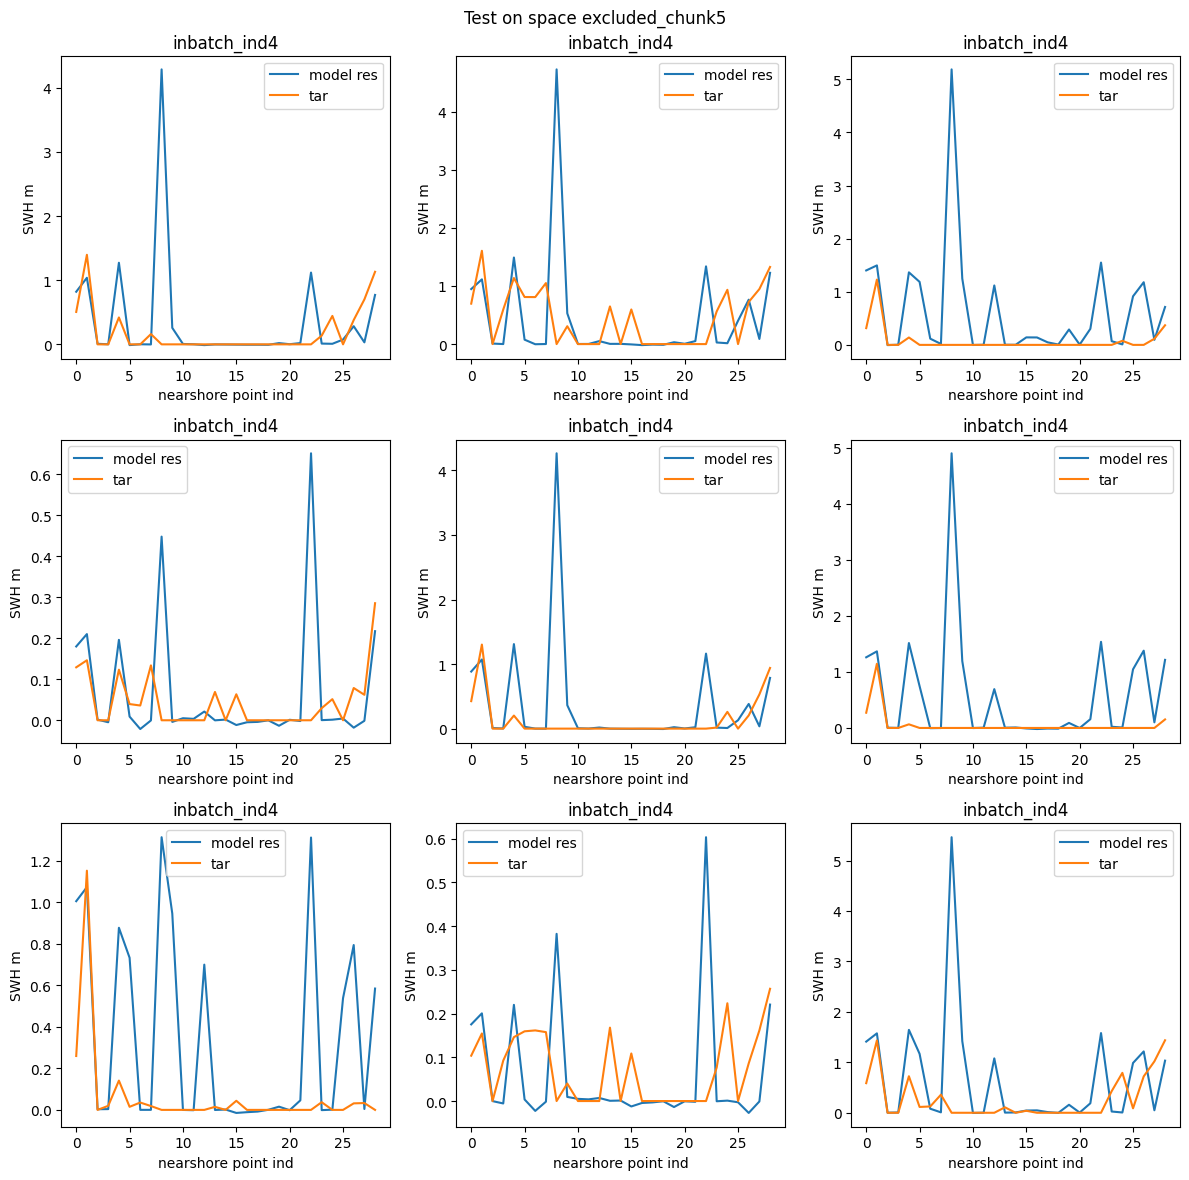

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

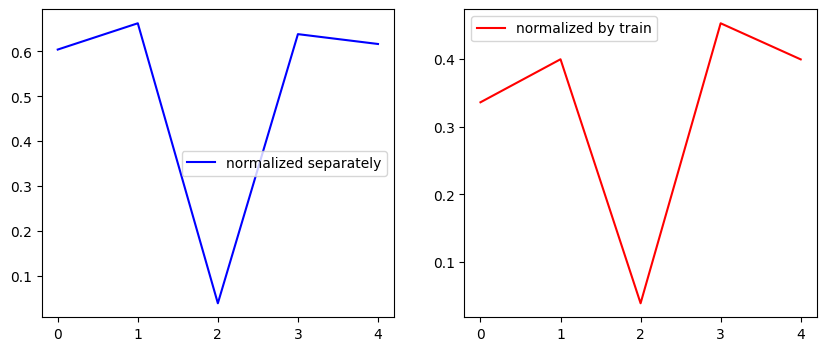

In [ ]:
midlist0 = spacegener(meanmid,stdmid,modelmid,0)
midlist1 = spacegener(meanmid,stdmid,modelmid,1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].plot(midlist0,label='normalized separately',color='blue')
axes[0].legend()

axes[1].plot(midlist1,label='normalized by train',color='red')
axes[1].legend()